In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import to_datetime
from prophet import Prophet

/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('anamoly_data_2006.csv')

In [3]:
print('dataframe shape {} '.format(df.shape))

dataframe shape (20803, 4) 


In [4]:
print(df.head(10))

         date  l_ipn  r_asn   f
0  2006-07-01      0    701   1
1  2006-07-01      0    714   1
2  2006-07-01      0   1239   1
3  2006-07-01      0   1680   1
4  2006-07-01      0   2514   1
5  2006-07-01      0   3320   1
6  2006-07-01      0   3561  13
7  2006-07-01      0   4134   3
8  2006-07-01      0   5617   2
9  2006-07-01      0   6478   1


In [5]:
print('Number of days for which data is available {:d}'.format(df['date'].nunique()))
print('Unique local ip {:d}'.format(df['l_ipn'].nunique()))
print('Unique remote ASN {:d}'.format(df['r_asn'].nunique()))
print('Minimum flow count per day {:d}'.format(df['f'].min()))
print('Maximum flow count per day {:d}'.format(df['f'].max()))

Number of days for which data is available 92
Unique local ip 10
Unique remote ASN 2005
Minimum flow count per day 1
Maximum flow count per day 784234


In [6]:
#Missing or NAN values in dataset
df.isnull().sum()

date     0
l_ipn    0
r_asn    0
f        0
dtype: int64

In [7]:
dic = {'2006-08-24':1,'2006-09-04':5,'2006-09-18':4,'2006-09-26':3,'2006-09-26':6}
marked_anomalies = pd.DataFrame.from_dict(dic,orient='index')
marked_anomalies.reset_index(inplace = True)
marked_anomalies.columns = ['date','l_ipn']
print(marked_anomalies)

         date  l_ipn
0  2006-08-24      1
1  2006-09-04      5
2  2006-09-18      4
3  2006-09-26      6


In [8]:
#Aggregating daily connections
daily_aggregate = df.groupby(['date'])[['f']].sum()
daily_aggregate.reset_index(inplace = True)

In [9]:
daily_aggregate[['f']].describe()

,f
count,92.000000
mean,21235.847826
std,85752.692609
min,2706.000000
25%,5211.750000
50%,8773.500000
75%,12426.000000
max,788297.000000


In [10]:
daily_mean = round(daily_aggregate['f'].mean(),2)

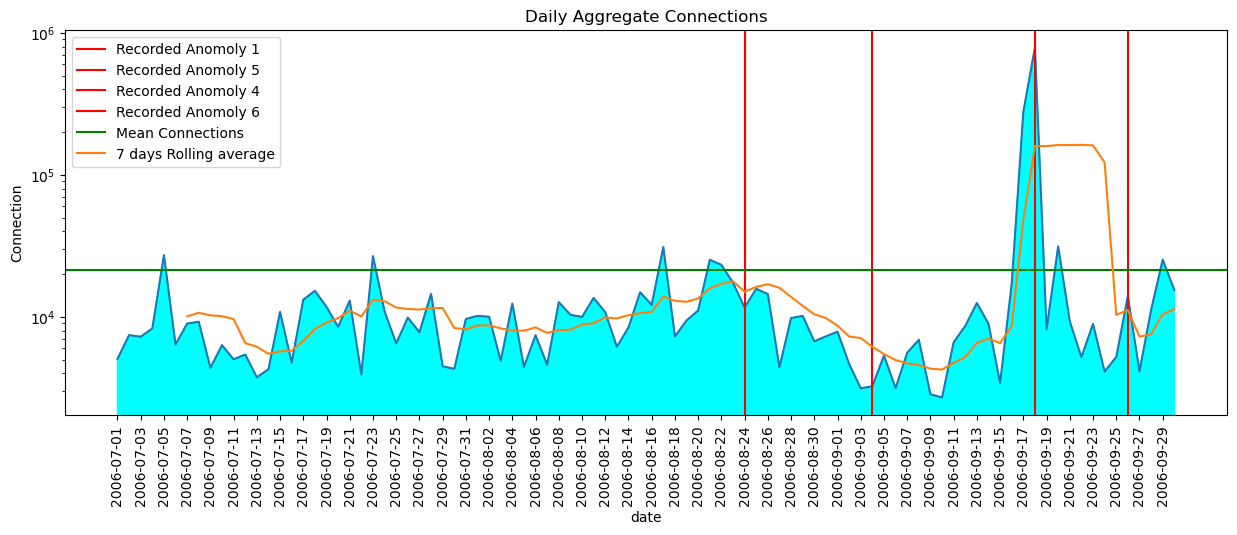

In [11]:
plt.figure(figsize=(15,5))
plt.plot(daily_aggregate['date'],daily_aggregate['f'])
[plt.axvline(x=_x, color='r' , label = 'Recorded Anomoly {}'.format(ip)) for _x,ip in list(marked_anomalies[['date','l_ipn']].to_records(index=False))]
plt.axhline(y= daily_mean, color='g', label = 'Mean Connections')
plt.plot(daily_aggregate['date'],daily_aggregate['f'].rolling(7).mean(), label = '7 days Rolling average')
plt.xticks(daily_aggregate['date'][::2],  rotation='vertical')
plt.yscale('log')
plt.xlabel('date')
plt.ylabel('Connection')
plt.title('Daily Aggregate Connections')
plt.fill_between(daily_aggregate['date'],daily_aggregate['f'],color='aqua')
plt.legend()
plt.show()

In [12]:
daily_aggregate_l_ipn = df.groupby(['l_ipn','date'])[['f']].sum()
daily_aggregate_l_ipn.reset_index(inplace= True)

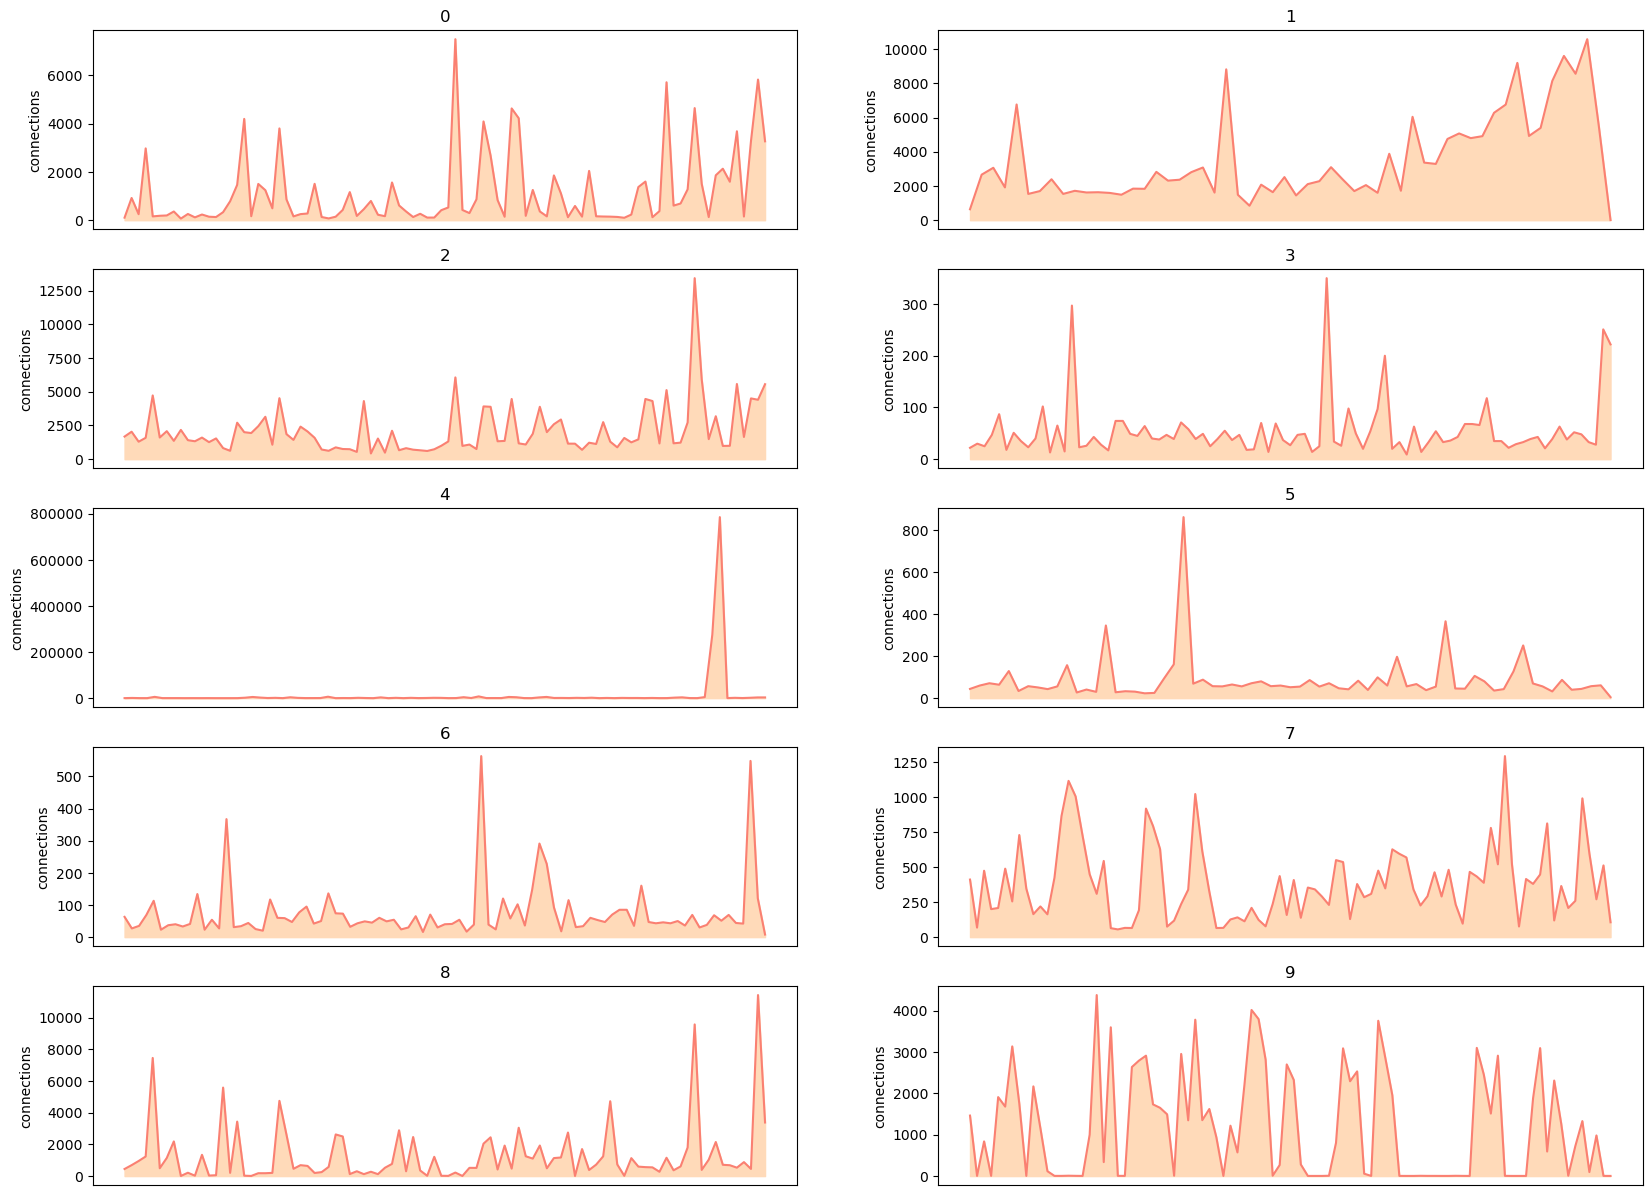

In [13]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 15))

plot_row = 0
plot_col = 0

for i in range(df['l_ipn'].nunique()):
    temp = daily_aggregate_l_ipn[daily_aggregate_l_ipn['l_ipn'] == i]
    axes[plot_row,plot_col].set_title(i)
    axes[plot_row,plot_col].set_xlabel('date')
    axes[plot_row,plot_col].set_ylabel('connections')
    
    axes[plot_row,plot_col].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    axes[plot_row,plot_col].plot(temp['date'],temp['f'], color = 'salmon')
    axes[plot_row,plot_col].get_xaxis().set_visible(False)
    axes[plot_row,plot_col].fill_between(temp['date'],temp['f'], color='peachpuff')
    

    plot_col = plot_col + 1
    if(plot_col == 2):
        plot_row = plot_row + 1
        plot_col = 0
plt.show()

In [14]:
daily_aggregate_r_asn = df.groupby(['r_asn'])[['f']].sum()
daily_aggregate_r_asn.reset_index(inplace = True)

In [15]:
pd.options.display.float_format = '{:.2f}'.format
daily_aggregate_r_asn['f'].describe()

count      2005.00
mean        974.41
std       23862.63
min           1.00
25%           2.00
50%           8.00
75%          43.00
max     1059254.00
Name: f, dtype: float64

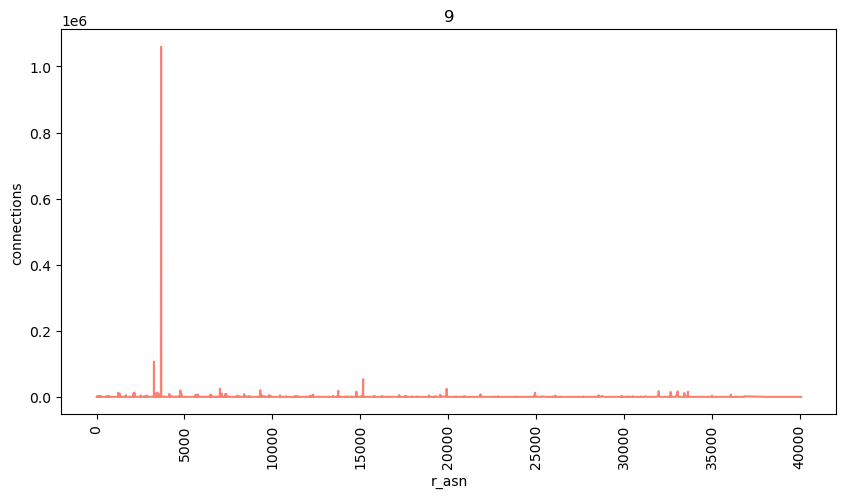

In [16]:
plt.figure(figsize=(10,5))
plt.title(i)
plt.xlabel('r_asn')
plt.ylabel('connections')
plt.xticks(rotation='vertical')
#n_bins =  daily_aggregate_r_asn['r_asn']
#plt.hist(daily_aggregate_r_asn['f'], n_bins, histtype ='bar')
plt.plot(daily_aggregate_r_asn['r_asn'],daily_aggregate_r_asn['f'], color = 'salmon')
plt.show()

In [17]:
def get_daily_aggregate_l_ipn(in_l_ipn):
    temp_df = daily_aggregate_l_ipn[daily_aggregate_l_ipn['l_ipn'] == in_l_ipn].drop(['l_ipn'],axis = 1)
    temp_df.columns = ['ds','y']
    temp_df['ds'] = to_datetime(temp_df['ds'])
    temp_df.reset_index(inplace=True,drop=True)
    return temp_df

In [18]:
def get_forecast(ts,in_l_ipn):
    
    model = Prophet(seasonality_mode='additive',daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = True)
    model.fit(ts)
    forecast = model.predict(pd.DataFrame(ts['ds']))
    
    ts['anomaly'] = 0
    p_color = np.full((ts.shape[0],1),'green')
    for i in range(forecast.shape[0]):
        if((forecast.at[i,'yhat_lower'] > ts.at[i,'y']) or (forecast.at[i,'yhat_upper'] < ts.at[i,'y'])):
            ts.at[i,'anomaly'] = 1
            p_color[i] = 'red'
                
    model.plot(forecast)
    
    plt.scatter(ts['ds'],ts['y'],c=p_color.ravel())
    plt.title('Forcast plot for l_ipn %d' %in_l_ipn)
    plt.show()

/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -55.7654
Iteration  1. Log joint probability =    68.5637. Improved by 124.329.
Iteration  2. Log joint probability =    102.084. Improved by 33.5199.
Iteration  3. Log joint probability =    105.272. Improved by 3.18894.
Iteration  4. Log joint probability =    105.674. Improved by 0.401743.
Iteration  5. Log joint probability =    105.876. Improved by 0.201501.
Iteration  6. Log joint probability =    106.085. Improved by 0.209304.
Iteration  7. Log joint probability =    106.096. Improved by 0.0113128.
Iteration  8. Log joint probability =    106.157. Improved by 0.0601819.
Iteration  9. Log joint probability =    106.174. Improved by 0.0174013.
Iteration 10. Log joint probability =     106.23. Improved by 0.0556623.
Iteration 11. Log joint probability =    106.263. Improved by 0.0329905.
Iteration 12. Log joint probability =    106.293. Improved by 0.0302428.
Iteration 13. Log joint probability =    106.296. Improved by 0.00351435.
Iteration 14. Log

/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


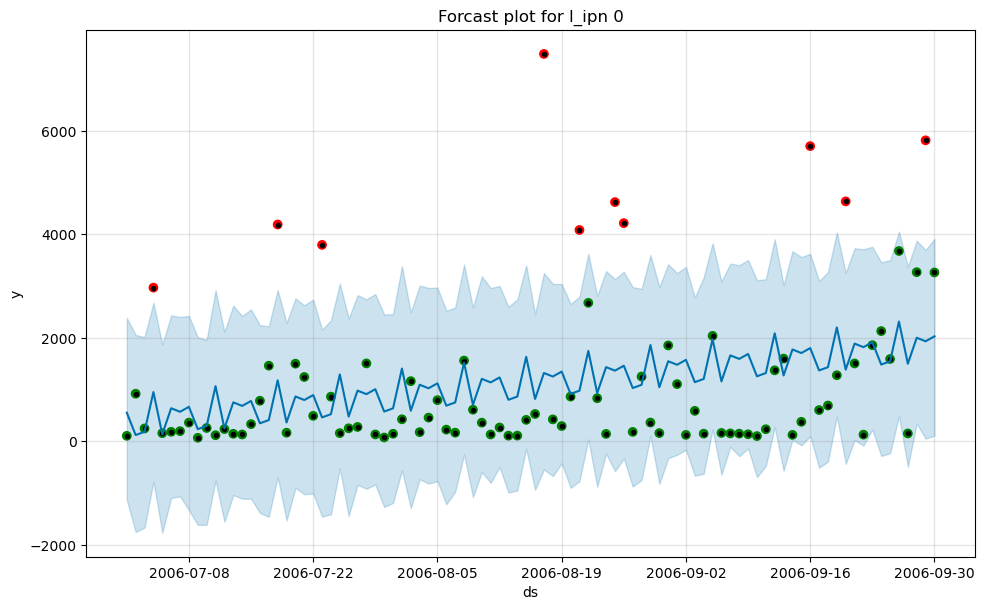

/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -24.71
Iteration  1. Log joint probability =    29.7493. Improved by 54.4593.
Iteration  2. Log joint probability =    60.9838. Improved by 31.2345.
Iteration  3. Log joint probability =    62.7711. Improved by 1.78726.
Iteration  4. Log joint probability =    65.5913. Improved by 2.82026.
Iteration  5. Log joint probability =    65.9761. Improved by 0.384777.
Iteration  6. Log joint probability =    66.1353. Improved by 0.1592.
Iteration  7. Log joint probability =    66.2423. Improved by 0.107015.
Iteration  8. Log joint probability =    66.2547. Improved by 0.0124171.
Iteration  9. Log joint probability =    66.2729. Improved by 0.0181266.
Iteration 10. Log joint probability =    66.3009. Improved by 0.0280089.
Iteration 11. Log joint probability =    66.3143. Improved by 0.0133891.
Iteration 12. Log joint probability =    66.3212. Improved by 0.00697342.
Iteration 13. Log joint probability =    66.3353. Improved by 0.0140647.
Iteration 14. Log joint

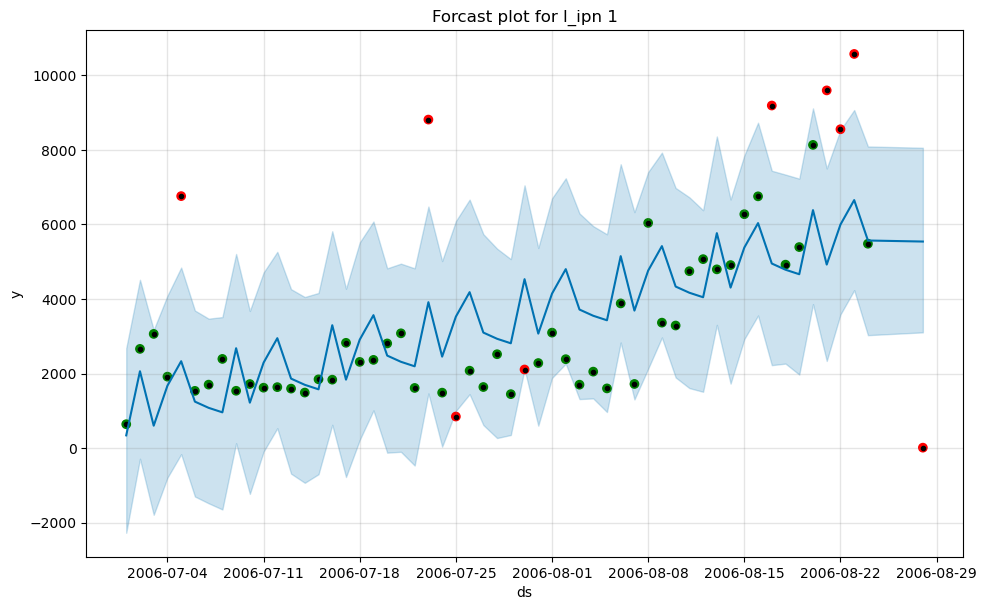

/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -55.046
Iteration  1. Log joint probability =     69.413. Improved by 124.459.
Iteration  2. Log joint probability =    126.226. Improved by 56.8127.
Iteration  3. Log joint probability =    126.259. Improved by 0.033737.
Iteration  4. Log joint probability =    135.422. Improved by 9.16282.
Iteration  5. Log joint probability =    135.452. Improved by 0.0296175.
Iteration  6. Log joint probability =    135.505. Improved by 0.0534645.
Iteration  7. Log joint probability =    135.584. Improved by 0.0787801.
Iteration  8. Log joint probability =    135.588. Improved by 0.00415813.
Iteration  9. Log joint probability =    135.683. Improved by 0.0944258.
Iteration 10. Log joint probability =    135.741. Improved by 0.0581799.
Iteration 11. Log joint probability =    135.842. Improved by 0.101449.
Iteration 12. Log joint probability =    135.946. Improved by 0.103564.
Iteration 13. Log joint probability =     136.01. Improved by 0.0638859.
Iteration 14. Log 

/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


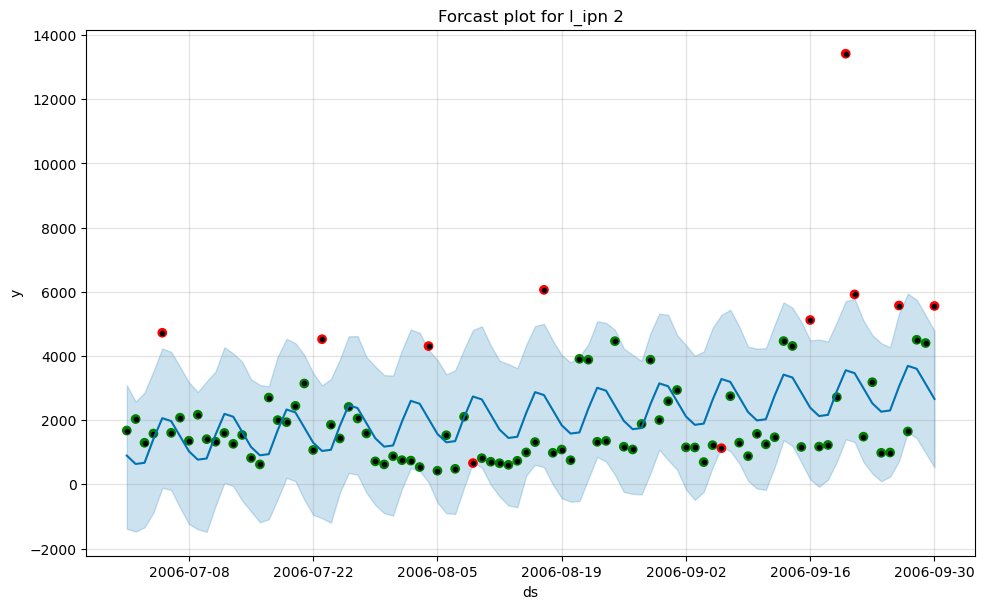

/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -54.6086
Iteration  1. Log joint probability =   -3.22359. Improved by 51.385.
Iteration  2. Log joint probability =    86.3485. Improved by 89.5721.
Iteration  3. Log joint probability =    86.3767. Improved by 0.0281443.
Iteration  4. Log joint probability =    86.4046. Improved by 0.0279138.
Iteration  5. Log joint probability =     86.448. Improved by 0.0433921.
Iteration  6. Log joint probability =    86.4824. Improved by 0.0344181.
Iteration  7. Log joint probability =    103.091. Improved by 16.6083.
Iteration  8. Log joint probability =    103.165. Improved by 0.0747335.
Iteration  9. Log joint probability =    103.172. Improved by 0.00623235.
Iteration 10. Log joint probability =    103.186. Improved by 0.0138495.
Iteration 11. Log joint probability =    103.319. Improved by 0.133192.
Iteration 12. Log joint probability =    103.434. Improved by 0.115498.
Iteration 13. Log joint probability =    103.466. Improved by 0.0316377.
Iteration 14. Log

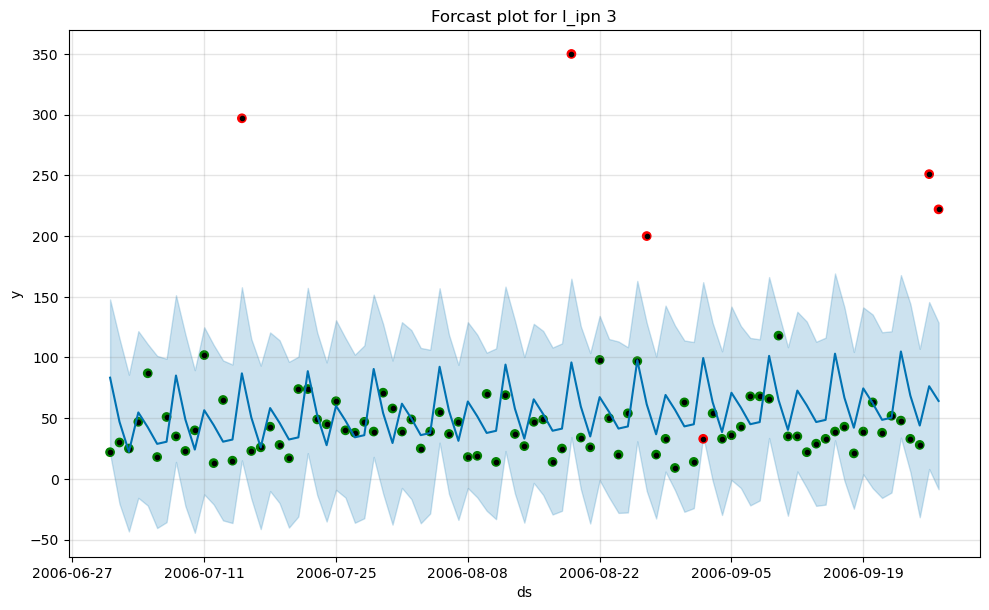

/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -48.6326
Iteration  1. Log joint probability =    85.8007. Improved by 134.433.
Iteration  2. Log joint probability =    135.753. Improved by 49.9525.
Iteration  3. Log joint probability =    140.563. Improved by 4.81004.
Iteration  4. Log joint probability =    140.573. Improved by 0.00988061.
Iteration  5. Log joint probability =    140.668. Improved by 0.0947789.
Iteration  6. Log joint probability =    140.675. Improved by 0.00754033.
Iteration  7. Log joint probability =     141.27. Improved by 0.594173.
Iteration  8. Log joint probability =    141.354. Improved by 0.0848757.
Iteration  9. Log joint probability =    141.597. Improved by 0.242847.
Iteration 10. Log joint probability =     142.05. Improved by 0.452608.
Iteration 11. Log joint probability =    142.222. Improved by 0.171618.
Iteration 12. Log joint probability =    142.833. Improved by 0.611196.
Iteration 13. Log joint probability =    142.887. Improved by 0.054434.
Iteration 14. Log j

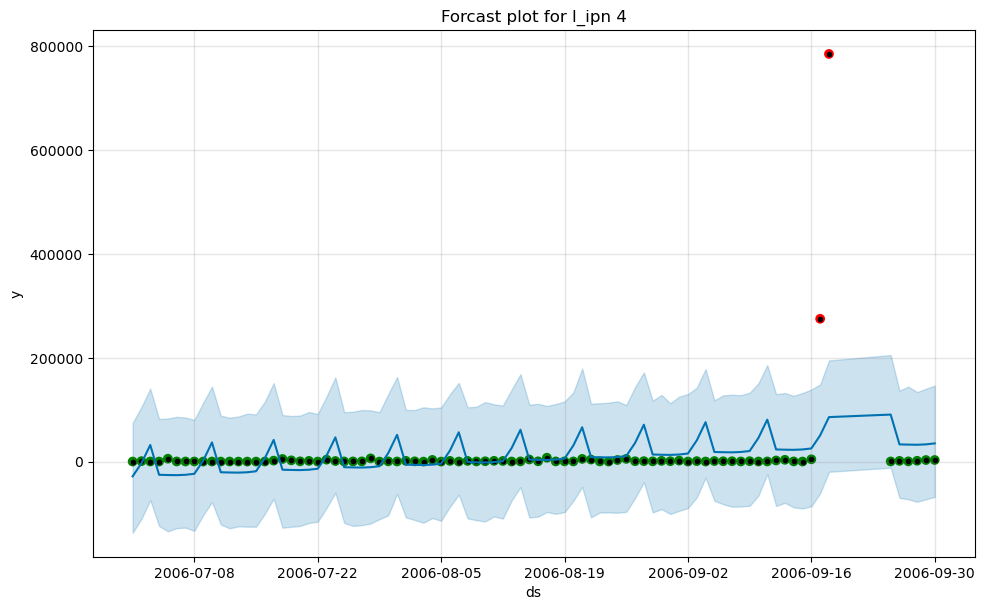

/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -31.3832
Iteration  1. Log joint probability =    18.6468. Improved by 50.03.
Iteration  2. Log joint probability =    104.883. Improved by 86.2363.
Iteration  3. Log joint probability =     105.61. Improved by 0.726551.
Iteration  4. Log joint probability =    105.736. Improved by 0.126104.
Iteration  5. Log joint probability =    105.784. Improved by 0.0486722.
Iteration  6. Log joint probability =    105.804. Improved by 0.0197568.
Iteration  7. Log joint probability =     105.81. Improved by 0.00536756.
Iteration  8. Log joint probability =    105.848. Improved by 0.0383595.
Iteration  9. Log joint probability =    105.849. Improved by 0.000795766.
Iteration 10. Log joint probability =    105.849. Improved by 0.000709682.
Iteration 11. Log joint probability =    105.868. Improved by 0.0190282.
Iteration 12. Log joint probability =    105.873. Improved by 0.0047277.
Iteration 13. Log joint probability =    105.874. Improved by 0.00101314.
Iteration 1

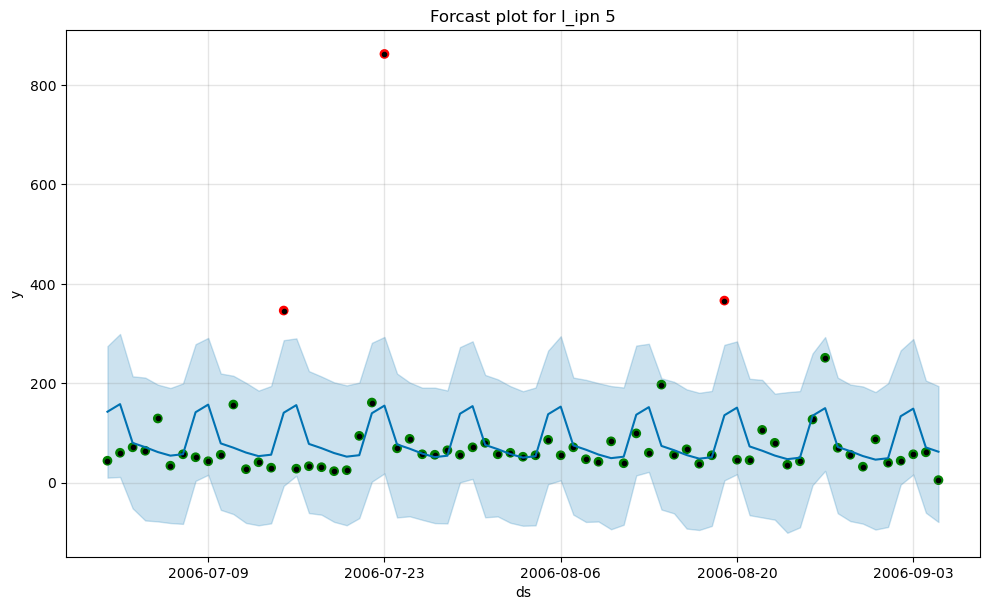

/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -52.2941
Iteration  1. Log joint probability =     79.315. Improved by 131.609.
Iteration  2. Log joint probability =     116.57. Improved by 37.2546.
Iteration  3. Log joint probability =    119.335. Improved by 2.76554.
Iteration  4. Log joint probability =    121.494. Improved by 2.15872.
Iteration  5. Log joint probability =    122.536. Improved by 1.0424.
Iteration  6. Log joint probability =    122.546. Improved by 0.00933386.
Iteration  7. Log joint probability =    122.556. Improved by 0.0105505.
Iteration  8. Log joint probability =    122.569. Improved by 0.013284.
Iteration  9. Log joint probability =    122.572. Improved by 0.00277881.
Iteration 10. Log joint probability =    122.575. Improved by 0.00234225.
Iteration 11. Log joint probability =    122.578. Improved by 0.00303765.
Iteration 12. Log joint probability =    122.579. Improved by 0.000975666.
Iteration 13. Log joint probability =    122.579. Improved by 0.000720708.
Iteration 14.

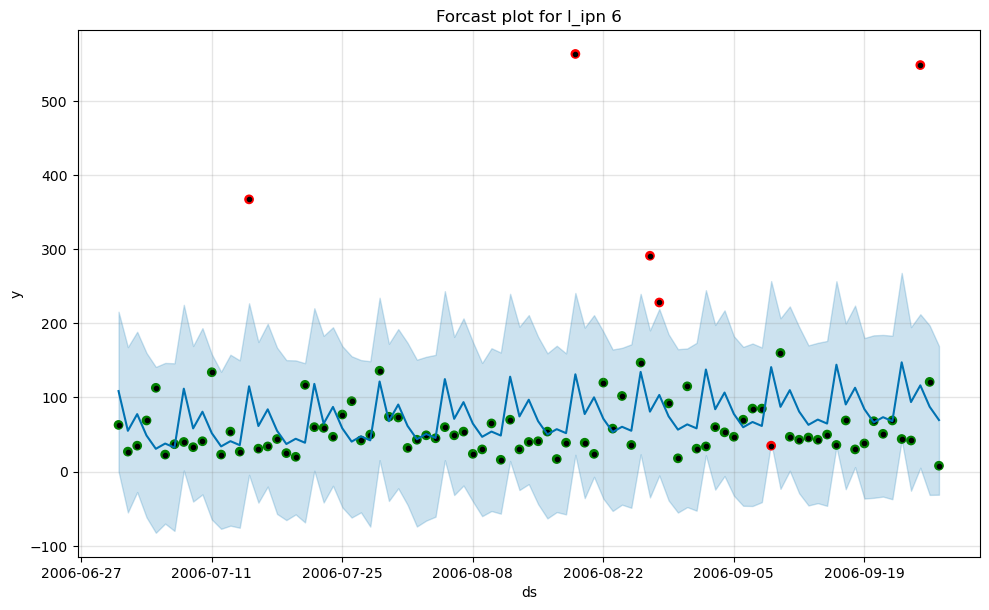

/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -56.2837
Iteration  1. Log joint probability =    69.5796. Improved by 125.863.
Iteration  2. Log joint probability =    99.4043. Improved by 29.8247.
Iteration  3. Log joint probability =    102.786. Improved by 3.38197.
Iteration  4. Log joint probability =    102.839. Improved by 0.0531186.
Iteration  5. Log joint probability =    102.856. Improved by 0.0170077.
Iteration  6. Log joint probability =     102.86. Improved by 0.00389956.
Iteration  7. Log joint probability =    102.884. Improved by 0.0240982.
Iteration  8. Log joint probability =    102.991. Improved by 0.106944.
Iteration  9. Log joint probability =    103.067. Improved by 0.0758018.
Iteration 10. Log joint probability =     103.13. Improved by 0.0626301.
Iteration 11. Log joint probability =    103.139. Improved by 0.0088062.
Iteration 12. Log joint probability =    103.198. Improved by 0.0592004.
Iteration 13. Log joint probability =    103.213. Improved by 0.015139.
Iteration 14. Lo

/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


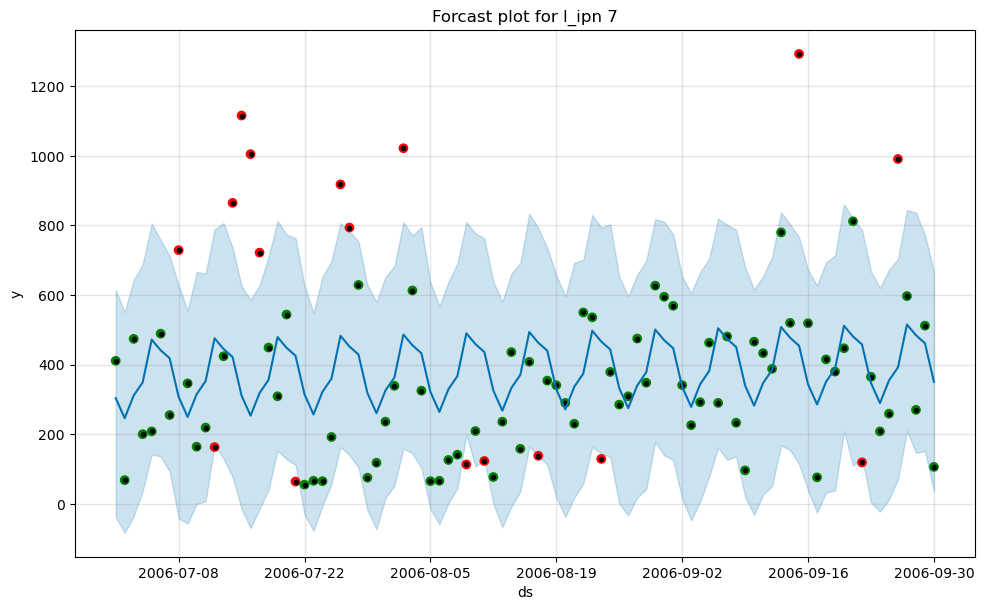

/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -55.1
Iteration  1. Log joint probability =    79.6761. Improved by 134.776.
Iteration  2. Log joint probability =    108.539. Improved by 28.8627.
Iteration  3. Log joint probability =    114.604. Improved by 6.06522.
Iteration  4. Log joint probability =    118.218. Improved by 3.61379.
Iteration  5. Log joint probability =    118.229. Improved by 0.0117362.
Iteration  6. Log joint probability =    118.271. Improved by 0.0411919.
Iteration  7. Log joint probability =    118.308. Improved by 0.037412.
Iteration  8. Log joint probability =    118.327. Improved by 0.0184629.
Iteration  9. Log joint probability =    118.357. Improved by 0.0299612.
Iteration 10. Log joint probability =    118.364. Improved by 0.00748384.
Iteration 11. Log joint probability =    118.421. Improved by 0.0572866.
Iteration 12. Log joint probability =    118.468. Improved by 0.0465002.
Iteration 13. Log joint probability =    118.474. Improved by 0.00668856.
Iteration 14. Log j

/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


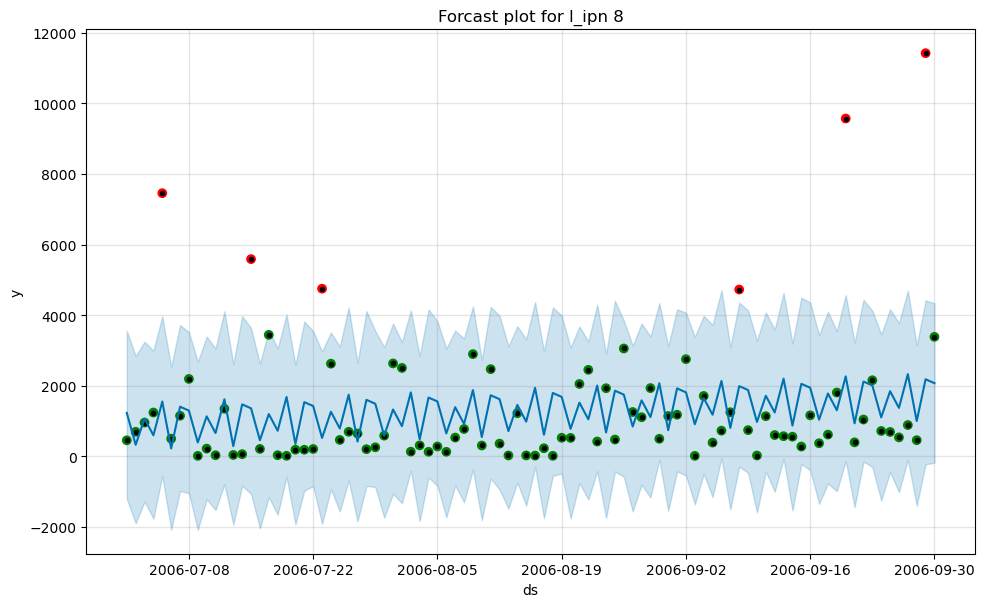

/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/dhruvilprajapati/opt/anaconda3/envs/ECE681/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -58.1048
Iteration  1. Log joint probability =    55.3483. Improved by 113.453.
Iteration  2. Log joint probability =    78.1775. Improved by 22.8292.
Iteration  3. Log joint probability =    80.0042. Improved by 1.82666.
Iteration  4. Log joint probability =     80.298. Improved by 0.293822.
Iteration  5. Log joint probability =    80.3269. Improved by 0.0289199.
Iteration  6. Log joint probability =    80.3458. Improved by 0.0188709.
Iteration  7. Log joint probability =    80.3473. Improved by 0.00145894.
Iteration  8. Log joint probability =    80.3578. Improved by 0.0105743.
Iteration  9. Log joint probability =    80.3628. Improved by 0.00495503.
Iteration 10. Log joint probability =    80.3644. Improved by 0.00162811.
Iteration 11. Log joint probability =    80.3647. Improved by 0.000243155.
Iteration 12. Log joint probability =    80.3652. Improved by 0.000537972.
Iteration 13. Log joint probability =    80.3671. Improved by 0.0018946.
Iteration

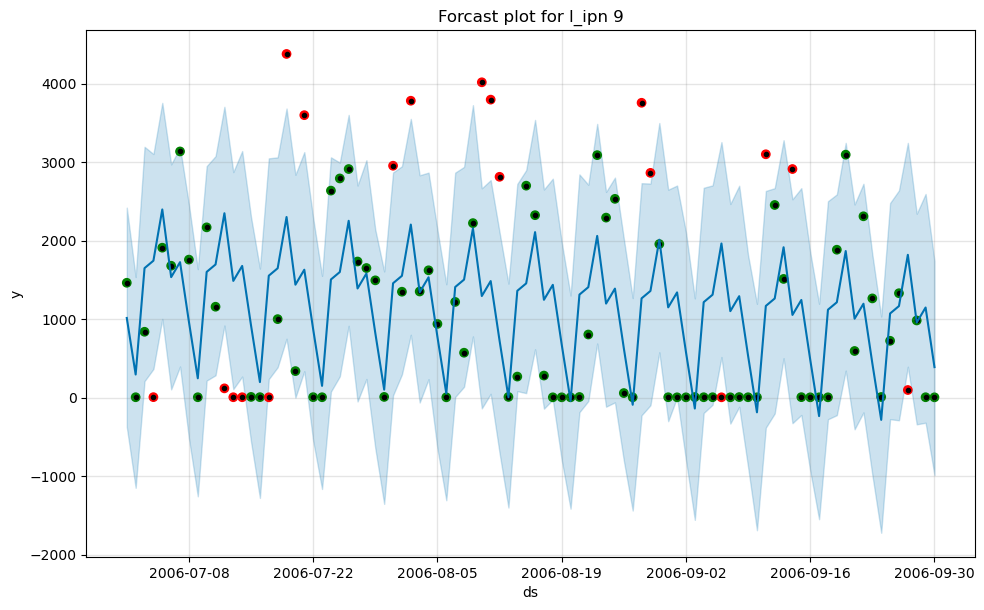

In [19]:
for i in range(df['l_ipn'].nunique()):
    get_forecast(get_daily_aggregate_l_ipn(i),i)